In [16]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import networkx as nx
import osmnx as ox
import geopandas as gpd
import networkx as nx
import folium
#from scripts.msr_functions import routes_to_featuregroup as routes_to_featuregroup

In [59]:
city_or_county = 'West Midlands'
network_type='drive'
target_address = '134 Herrick Road, Birmingham'

In [60]:
ox.config(log_console=True, use_cache=True)
target_location = ox.geocode(target_address)
G = ox.graph_from_place(city_or_county, network_type=network_type)
target = ox.nearest_nodes(G, target_location[1],Y=target_location[0])


2023-04-19 12:08:03 Configured OSMnx 1.1.2
2023-04-19 12:08:03 HTTP response caching is on
2023-04-19 12:08:04 Pausing 1 seconds before making HTTP GET request
2023-04-19 12:08:05 Get https://nominatim.openstreetmap.org/search?format=json&limit=1&dedupe=0&q=134+Herrick+Road%2C+Birmingham with timeout=180
2023-04-19 12:08:05 Resolved nominatim.openstreetmap.org to 184.104.226.109
2023-04-19 12:08:05 Downloaded 0.4kB from nominatim.openstreetmap.org
2023-04-19 12:08:05 Saved response to cache file "cache/5374e890248d6f4d7b52c246b1eb9a017b2f4e24.json"
2023-04-19 12:08:05 Geocoded "134 Herrick Road, Birmingham" to (52.4938645, -1.8536614)
2023-04-19 12:08:05 Pausing 1 seconds before making HTTP GET request
2023-04-19 12:08:06 Get https://nominatim.openstreetmap.org/search?format=json&polygon_geojson=1&dedupe=0&limit=50&q=West+Midlands with timeout=180
2023-04-19 12:08:06 Resolved nominatim.openstreetmap.org to 184.104.226.109
2023-04-19 12:08:06 Downloaded 1,444.4kB from nominatim.openstre

/Users/paulcarroll/Github/nhs_time_of_travel/geospat/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


2023-04-19 12:08:07 Projected GeoDataFrame to epsg:4326
2023-04-19 12:08:07 Projected GeoDataFrame to +proj=utm +zone=30 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs
2023-04-19 12:08:07 Projected GeoDataFrame to epsg:4326
2023-04-19 12:08:07 Requesting data within polygon from API in 1 request(s)
2023-04-19 12:08:07 Resolved overpass-api.de to 162.55.144.139
2023-04-19 12:08:07 Unrecognized server status: "Rate limit: 6"
2023-04-19 12:08:07 Pausing 60 seconds before making HTTP POST request
2023-04-19 12:09:07 Post https://overpass-api.de/api/interpreter?data=%5Bout%3Ajson%5D%5Btimeout%3A180%5D%3B%28way%5B%22highway%22%5D%5B%22area%22%21~%22yes%22%5D%5B%22access%22%21~%22private%22%5D%5B%22highway%22%21~%22abandoned%7Cbridleway%7Cbus_guideway%7Cconstruction%7Ccorridor%7Ccycleway%7Celevator%7Cescalator%7Cfootway%7Cpath%7Cpedestrian%7Cplanned%7Cplatform%7Cproposed%7Craceway%7Cservice%7Csteps%7Ctrack%22%5D%5B%22motor_vehicle%22%21~%22no%22%5D%5B%22motorcar%22%21~%22no%22%5D%5B%22

In [36]:

# Get all walkable roads and the nodes 
'''
osmCambridge = OSM(get_data("Cambridge"))
nodes, edges = osmCambridge.get_network(nodes=True)
'''

'\nosmCambridge = OSM(get_data("Cambridge"))\nnodes, edges = osmCambridge.get_network(nodes=True)\n'

2023-04-19 12:10:32 Begin plotting the graph...
2023-04-19 12:10:41 Created edges GeoDataFrame from graph
2023-04-19 12:10:56 Created nodes GeoDataFrame from graph


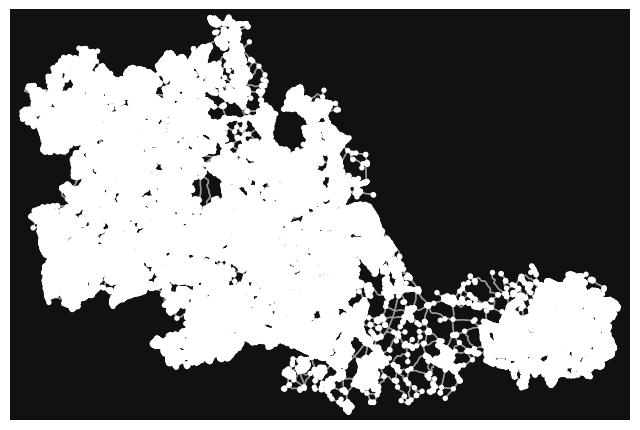

2023-04-19 12:10:58 Finished plotting the graph


(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [61]:
ox.plot_graph(G)

In [8]:
#G = osmCambridge.to_graph(nodes, edges, graph_type="networkx")

In [63]:
# hospital data function
# testing the workbook to take into account how to process data from hospital.csv for tsp use.

def hospital_data():
    hospitals = pd.read_csv('../data/Hospital.csv',sep=',')
    hospitals = hospitals.dropna(subset=['County'])
    hospital = hospitals[(hospitals['City'].str.contains (city_or_county))].reset_index(drop = True)
    hospital['Address'] = hospital[['Address1','Address2','Address3']].astype(str).agg(', '.join,axis=1)
    #hospital['Address'] = hospital[['Address', 'coord','County']].astype(str).agg(', '.join, axis=1)
    hospital['Address'] = hospital['Address'].str.title() 
    hospital['Address'] = hospital['Address'].str.replace('Nan', '').str.replace(',', ' ')
    hospital['Name'] = hospital['OrganisationName'].str.title()
    
    hospital = hospital[['Name', 'Address','City','County','Latitude','Longitude']]
    return hospital

In [64]:

hospitals = pd.read_csv('../data/Hospital.csv',sep=',')
hospitals = hospitals.dropna(subset=['County'])
hospital = hospitals[(hospitals['City'].str.contains ('Birmingham'))].reset_index(drop = True)
hospital['Address'] = hospital[['Address1','Address2','Address3',]].astype(str).agg(','.join,axis=1)
#hospital['Address'] = hospital[['Address', 'coord','County']].astype(str).agg(', '.join, axis=1)
hospital['Address'] = hospital['Address'].str.title() 
hospital['Address'] = hospital['Address'].str.replace('Nan', '').str.replace(' ,', ' ')
hospital['Name'] = hospital['OrganisationName'].str.title()
hospital = hospital[['Name', 'Address','City','County','Latitude','Longitude']]

In [65]:
hospital

,Name,Address,City,County,Latitude,Longitude
0,Bmi The Priory Hospital,"Priory Road,Edgbaston,",Birmingham,West Midlands,52.456432,-1.911409
1,Bmi The Edgbaston Hospital,"22 Somerset Road,Edgbaston,",Birmingham,West Midlands,52.457588,-1.932878
2,Woodbourne Priory Hospital,"21 Woodbourne Road,Edgbaston,",Birmingham,West Midlands,52.471695,-1.955807
3,Optegra Eye Hospital Birmingham,",Coleshill Street,",Birmingham,West Midlands,52.486641,-1.890938
4,Royal Orthopaedic Hospital,"The Woodlands,Bristol Road South,Northfield",Birmingham,West Midlands,52.421139,-1.960813
5,City Hospital,"Dudley Road,Dudley Road,",Birmingham,West Midlands,52.488632,-1.932492
6,Ardenleigh,"385 Kingsbury Road,Erdington,",Birmingham,West Midlands,52.517456,-1.834641
7,Ashcroft,"Ashcroft Complex Care Unit,The Moorings,Hockley",Birmingham,West Midlands,52.493862,-1.932396
8,Endeavour Court,",210 Reservoir Road,Erdington",Birmingham,West Midlands,52.523884,-1.857315
9,Mary Seacole House,",Lodge Road,Winson Green",Birmingham,West Midlands,52.493862,-1.932396


In [66]:
filtered_df=hospital

In [91]:
import math

use_long_lat = False
if 'Longitude' in filtered_df.columns and 'Latitude' in filtered_df.columns:
    use_long_lat = True
routes = []
lengths=[]
names=[]
for _,row in filtered_df.iterrows():
    try:
        if use_long_lat:
            coords = (row['Latitude'], row['Longitude'])
        else:
            coords = ox.geocoder.geocode(row['Address'])
        nodes = ox.nearest_nodes(G,X=coords[1],Y=coords[0])
        routes.append(nx.shortest_path(G,nodes,target,weight="length"))
        lengths.append(nx.shortest_path_length(G,source=nodes,target=target,weight='length')/1609.34)
        names.append(row['Name'])
    except Exception as e:
        lengths.append(math.nan)
        pass

2023-04-19 12:50:36 Created nodes GeoDataFrame from graph
2023-04-19 12:50:36 Created nodes GeoDataFrame from graph
2023-04-19 12:50:37 Created nodes GeoDataFrame from graph
2023-04-19 12:50:37 Created nodes GeoDataFrame from graph
2023-04-19 12:50:38 Created nodes GeoDataFrame from graph
2023-04-19 12:50:38 Created nodes GeoDataFrame from graph
2023-04-19 12:50:39 Created nodes GeoDataFrame from graph
2023-04-19 12:50:39 Created nodes GeoDataFrame from graph
2023-04-19 12:50:40 Created nodes GeoDataFrame from graph
2023-04-19 12:50:40 Created nodes GeoDataFrame from graph
2023-04-19 12:50:41 Created nodes GeoDataFrame from graph
2023-04-19 12:50:42 Created nodes GeoDataFrame from graph
2023-04-19 12:50:42 Created nodes GeoDataFrame from graph
2023-04-19 12:50:43 Created nodes GeoDataFrame from graph
2023-04-19 12:50:43 Created nodes GeoDataFrame from graph
2023-04-19 12:50:44 Created nodes GeoDataFrame from graph
2023-04-19 12:50:45 Created nodes GeoDataFrame from graph
2023-04-19 12:

In [92]:
names

['Bmi The Priory Hospital',
 'Bmi The Edgbaston Hospital',
 'Woodbourne Priory Hospital',
 'Optegra Eye Hospital Birmingham',
 'Royal Orthopaedic Hospital',
 'City Hospital',
 'Ardenleigh',
 'Ashcroft',
 'Endeavour Court',
 'Mary Seacole House',
 'Reaside Clinic',
 'Reservoir Court',
 'Zinnia Centre',
 'Oleaster',
 'Brooklands Hospital',
 'West Heath Hospital',
 'Eden Unit',
 'Forward House',
 'Beverley House',
 "Birmingham Women'S Hospital",
 'West Midlands Rehabilitation Centre',
 'Heartlands Hospital',
 'Cygnet Wast Hills']

In [93]:
def routes_to_featuregroup(G, routes, color, name):
    '''
    Convert a networkx route into a folium FeatureGroup
    
    Args:
        G: Networkx graph of area 
        routes: list of routes, each of which is a list of node indices
        color: color for lines in folium 
        name: name for resulting feature group

    Returns:
        a feature group with all routes as lines
    '''
    layer = folium.FeatureGroup(name=name)
    lines = [] 
    if routes:
        for route in routes:
            route_coords =[]
            for node in route:
                route_coords.append((G.nodes[node]['y'], G.nodes[node]['x']))
            lines.append(route_coords)
    folium.PolyLine(lines, color=color, weight=2, opacity=0.5).add_to(layer)
    
    return layer

In [94]:
route_map = ox.plot_route_folium(G,routes[0])
colors=['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
num_colors = len(colors)
color = colors[i % num_colors]

2023-04-19 12:50:48 Created edges GeoDataFrame from graph


In [95]:
layer = folium.FeatureGroup(name=name)
lines = [] 
if routes:
    for route in routes:
        route_coords =[]
        for node in route:
            route_coords.append((G.nodes[node]['y'], G.nodes[node]['x']))
        lines.append(route_coords)
folium.PolyLine(lines, color=color, weight=2, opacity=0.5).add_to(layer)

In [96]:
len(lines)

23

In [97]:
for i, route in enumerate(routes):
    layer = routes_to_featuregroup(G, routes=[route], color=color, name=names[i])
    layer.add_to(route_map)

In [98]:
def source_markers(row, route_map, color):
    target_loc = (row['Latitude'], row['Longitude'])
    iframe2 = folium.IFrame('<font face = "Arial"><b>{}</b> {}.</font>'.format(row['Name'],row['Address'],))
    popup2 = folium.Popup(iframe2, min_width=200, max_width=200, )
    folium.Marker(location=target_loc,popup = popup2, icon=folium.Icon(color=color)).add_to(route_map)


In [86]:
filtered_df['lengths'] = np.array(lengths)
colors=['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
num_colors = len(colors)
for i, (_,row) in enumerate(filtered_df.iterrows()):
    color = colors[i % num_colors]
    source_markers(row, route_map, color='red')
    # print('color ' , _, i, row)


In [99]:
folium.LayerControl().add_to(route_map)
route_map

In [100]:
filtered_df['Distance in Miles'] = np.array(lengths)
new_df = filtered_df[['Name', 'Address', 'Distance in Miles']].copy()
new_df['Distance in Miles'] = new_df['Distance in Miles'].round(2)
walking_speed = 3  # mph    
new_df['Walking time (min)'] = (new_df['Distance in Miles'] / walking_speed) * 60


In [101]:
new_df

,Name,Address,Distance in Miles,Walking time (min)
0,Bmi The Priory Hospital,"Priory Road,Edgbaston,",4.67,93.4
1,Bmi The Edgbaston Hospital,"22 Somerset Road,Edgbaston,",5.31,106.2
2,Woodbourne Priory Hospital,"21 Woodbourne Road,Edgbaston,",5.81,116.2
3,Optegra Eye Hospital Birmingham,",Coleshill Street,",2.41,48.2
4,Royal Orthopaedic Hospital,"The Woodlands,Bristol Road South,Northfield",7.92,158.4
5,City Hospital,"Dudley Road,Dudley Road,",4.41,88.2
6,Ardenleigh,"385 Kingsbury Road,Erdington,",2.78,55.6
7,Ashcroft,"Ashcroft Complex Care Unit,The Moorings,Hockley",4.01,80.2
8,Endeavour Court,",210 Reservoir Road,Erdington",3.11,62.2
9,Mary Seacole House,",Lodge Road,Winson Green",4.01,80.2


In [9]:
source_address1 = "39 Kings Hedges Road, Cambridge"
source_address2 = "6 High Cross, Cambridge"
source_address3 = "132 Church End, Cambridge"
source_address4 = "11 Leonard Close, Cambridge"
target_address = "Hills Road, Cambridge"

source1 = ox.geocode(source_address1)
source2 = ox.geocode(source_address2)
source3 = ox.geocode(source_address3)
source4 = ox.geocode(source_address4)
target = ox.geocode(target_address)

In [10]:
source_node1 = ox.get_nearest_node(G, source1)
source_node2 = ox.get_nearest_node(G, source2)
source_node3 = ox.get_nearest_node(G, source3)
source_node4 = ox.get_nearest_node(G, source4)

target_node = ox.get_nearest_node(G, target)

In [11]:
route1 = nx.shortest_path(G, source_node1, target_node, weight="length")
route2 = nx.shortest_path(G, source_node2, target_node, weight="length")
route3 = nx.shortest_path(G, source_node3, target_node, weight="length")
route4 = nx.shortest_path(G, source_node4, target_node, weight="length")

In [12]:
routes = [route1, route2, route3, route4]
#rc = ['r','y','c','g']
rc1 = ['r'] * (len(route1) - 1)
rc2 = ['b'] * len(route2)
rc3 = ['y'] * len(route3)
rc4 = ['g'] * len(route4)
rc = rc1 + rc2 + rc3 +rc4

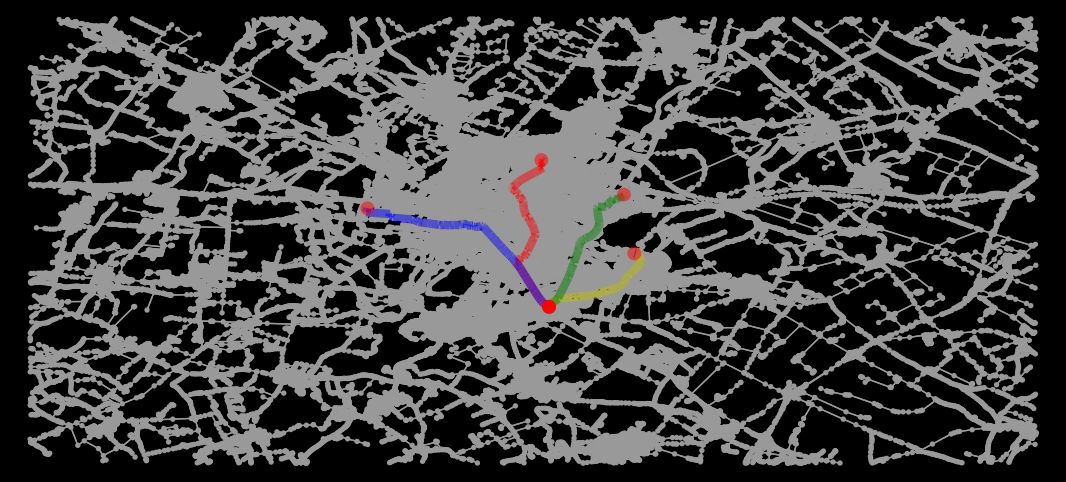

In [13]:
fig, ax = ox.plot_graph_routes(G, routes, route_color=rc, route_linewidth=6, bgcolor='k')

In [14]:
length1 = nx.shortest_path_length(G, source=source_node1, target=target_node, weight='length')
length2 = nx.shortest_path_length(G, source=source_node2, target=target_node, weight='length')
length3 = nx.shortest_path_length(G, source=source_node3, target=target_node, weight='length')
length4 = nx.shortest_path_length(G, source=source_node4, target=target_node, weight='length')

In [17]:
print('route1 length', round(length1,2))
print('route2 length', round(length2,2))
print('route3 length', round(length3,2))
print('route4 length', round(length4,2))


route1 length 6918.1
route2 length 6993.71
route3 length 3587.01
route4 length 5339.96
